In [1]:
import torch
from torch import nn
import pretrainedmodels

from utils.train import train
from utils.evaluation import evaluation
from utils.loader import get_loader, get_image_list
from utils.losses import CostSensitiveRegularizedLoss

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# hyper params
num_of_class = 102
learning_rate = 1e-04
batch_size = 128
input_size = 224
device = torch.device("cuda")
test_size = 0.2
train_size = 0.7
val_size = 0.1
directoryAgeDB = 'AgeDB/'

In [3]:
def findAge(image_list):
    listofzeros = [0] * 102
    same_age = [i for i in range(0, 102)]
    age_number = dict(zip(same_age, listofzeros))
    sum = 0

    for i in range(len(image_list)):

        if image_list[i]['age'] in age_number:
            age_number[image_list[i]['age']] += 1
            sum += 1

    print(sum)
    return dict(age_number)


In [4]:
train_image_list, test_image_list, validate_image_list = get_image_list(
    train_size=train_size, 
    test_size=test_size, 
    val_size=val_size, 
    directory=directoryAgeDB,
)

train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=3,
)

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  34623
Test Set Length:  3298
Validation Set Length:  1649
Total:  39570


In [5]:
resnet1 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet1.last_linear = nn.Linear(
    in_features=resnet1.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet2 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet2.last_linear = nn.Linear(
    in_features=resnet2.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet1 = resnet1.to(device)
resnet2 = resnet2.to(device)

In [6]:
from pytorch_metric_learning.losses import SphereFaceLoss
criteria = SphereFaceLoss(num_classes=num_of_class, embedding_size=num_of_class)
optimizer = torch.optim.Adam(resnet1.parameters(), lr=learning_rate, weight_decay=1e-1)
model_name = 'sphereface-aug.pth'

Epoch: 1/5, Train Loss: 5.672906119005266,  Validation Loss: 4.748769173255334
Validation Loss Decreased(inf ---> 4.748769173255334)
Epoch: 2/5, Train Loss: 4.736126952505639,  Validation Loss: 4.7393861917349005
Validation Loss Decreased(4.748769173255334 ---> 4.7393861917349005)
Epoch: 3/5, Train Loss: 4.728127349346766,  Validation Loss: 4.705525838411772
Validation Loss Decreased(4.7393861917349005 ---> 4.705525838411772)
Epoch: 4/5, Train Loss: 4.6991641389487855,  Validation Loss: 4.723685447986309
Epoch: 5/5, Train Loss: 4.682548040833421,  Validation Loss: 4.688868559323824
Validation Loss Decreased(4.705525838411772 ---> 4.688868559323824)


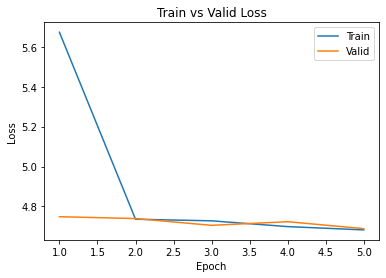

In [7]:
train(resnet1, optimizer, criteria, train_loader, validation_loader, num_of_epoch=5, model_name=model_name)

In [8]:
resnet1.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet1, test_loader)
_ = evaluation(resnet1, train_loader)

Mean Absolute Error: 19.155548095703125
Minimum: 0.0, Maximum: 73.0, Median: 16.0
Mean Absolute Error: 19.04196548461914
Minimum: 0.0, Maximum: 68.0, Median: 16.0


In [9]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 26.00
2  No Sample
3 : 2 : 24.00
4 : 1 : 23.00
5 : 1 : 22.00
6 : 2 : 30.00
7 : 2 : 20.00
8 : 2 : 19.00
9 : 1 : 18.00
10 : 3 : 17.00
11 : 4 : 20.50
12 : 3 : 15.00
13 : 4 : 14.00
14 : 5 : 13.00
15 : 9 : 12.00
16 : 10 : 15.10
17 : 16 : 15.12
18 : 24 : 12.75
19 : 22 : 10.68
20 : 32 : 12.22
21 : 33 : 7.64
22 : 37 : 6.46
23 : 42 : 7.86
24 : 52 : 5.87
25 : 57 : 5.33
26 : 55 : 4.45
27 : 61 : 3.20
28 : 69 : 3.78
29 : 62 : 4.19
30 : 77 : 5.56
31 : 63 : 6.38
32 : 75 : 7.05
33 : 67 : 6.99
34 : 72 : 7.68
35 : 82 : 8.49
36 : 69 : 9.00
37 : 74 : 9.65
38 : 76 : 10.26
39 : 64 : 10.69
40 : 77 : 11.68
41 : 64 : 12.98
42 : 71 : 13.28
43 : 65 : 13.49
44 : 56 : 14.61
45 : 68 : 14.99
46 : 57 : 16.84
47 : 58 : 17.83
48 : 62 : 17.52
49 : 53 : 18.21
50 : 63 : 19.13
51 : 57 : 17.28
52 : 62 : 21.77
53 : 50 : 22.36
54 : 51 : 21.96
55 : 59 : 22.56
56 : 45 : 25.29
57 : 49 : 25.76
58 : 49 : 26.96
59 : 43 : 30.33
60 : 49 : 29.86
61 : 41 : 29.80
62 : 48 : 30.83
63 : 44 : 30.16
64 : 3

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  11541
Test Set Length:  3298
Validation Set Length:  1649
Total:  16488
Epoch: 1/5, Train Loss: 7.428118946788075,  Validation Loss: 4.907127600449782
Validation Loss Decreased(inf ---> 4.907127600449782)
Epoch: 2/5, Train Loss: 4.816846606495616,  Validation Loss: 4.794305031116192
Validation Loss Decreased(4.907127600449782 ---> 4.794305031116192)
Epoch: 3/5, Train Loss: 4.753860861390502,  Validation Loss: 4.7399570391728325
Validation Loss Decreased(4.794305031116192 ---> 4.7399570391728325)
Epoch: 4/5, Train Loss: 4.7397076690589985,  Validation Loss: 4.802999276381272
Epoch: 5/5, Train Loss: 4.740888637500805,  Validation Loss: 4.7230054048391485
Validation Loss Decreased(4.7399570391728325 ---> 4.7230054048391485)


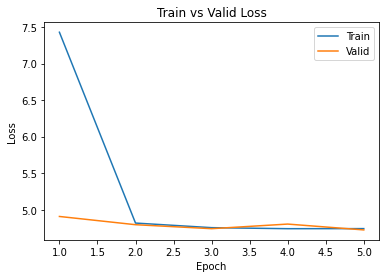

In [11]:
train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=1,
)
criteria = SphereFaceLoss(num_classes=num_of_class, embedding_size=num_of_class)
optimizer = torch.optim.Adam(resnet2.parameters(), lr=learning_rate, weight_decay=1e-1)
model_name = 'sphereface.pth'
train(resnet2, optimizer, criteria, train_loader, validation_loader, num_of_epoch=5, model_name=model_name)

In [12]:
resnet2.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet2, test_loader)
_ = evaluation(resnet2, train_loader)

Mean Absolute Error: 31.811098098754883
Minimum: 0.0, Maximum: 97.0, Median: 30.0
Mean Absolute Error: 31.848365783691406
Minimum: 0.0, Maximum: 98.0, Median: 31.0


In [13]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 59.00
2  No Sample
3 : 2 : 38.50
4 : 1 : 97.00
5 : 1 : 18.00
6 : 2 : 76.50
7 : 2 : 73.00
8 : 2 : 20.50
9 : 1 : 64.00
10 : 3 : 75.33
11 : 4 : 47.25
12 : 3 : 60.00
13 : 4 : 48.75
14 : 5 : 27.60
15 : 9 : 43.67
16 : 10 : 38.30
17 : 16 : 53.06
18 : 24 : 45.71
19 : 22 : 51.27
20 : 32 : 51.47
21 : 33 : 37.36
22 : 37 : 38.65
23 : 42 : 48.12
24 : 52 : 41.23
25 : 57 : 36.07
26 : 55 : 43.96
27 : 61 : 34.67
28 : 69 : 38.93
29 : 62 : 40.66
30 : 77 : 36.45
31 : 63 : 40.02
32 : 75 : 39.23
33 : 67 : 34.96
34 : 72 : 37.75
35 : 82 : 31.06
36 : 69 : 33.78
37 : 74 : 31.66
38 : 76 : 32.97
39 : 64 : 32.77
40 : 77 : 33.17
41 : 64 : 31.16
42 : 71 : 31.49
43 : 65 : 30.22
44 : 56 : 33.52
45 : 68 : 29.97
46 : 57 : 33.23
47 : 58 : 27.86
48 : 62 : 28.52
49 : 53 : 29.28
50 : 63 : 31.70
51 : 57 : 30.95
52 : 62 : 29.66
53 : 50 : 29.22
54 : 51 : 29.04
55 : 59 : 27.36
56 : 45 : 25.16
57 : 49 : 25.51
58 : 49 : 26.16
59 : 43 : 24.63
60 : 49 : 29.39
61 : 41 : 23.85
62 : 48 : 23.27
63 : 